In [1]:
%matplotlib inline

In [2]:
import json
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['svg.fonttype'] = 'none'

In [20]:
RAW_DATA = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/")
RAW_HASHED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/hashed_exec_resolution")
RAW_ATTENUATED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/forward_deferred")
RAW_TILED_DATA_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/raw/tiled_exec_resolution")

ANALYSIS_ROOT = Path("C:/Users/Monthy/Documents/projects/thesis/thesis-data-suite/data/analysis/hashed_exec")

In [35]:
SCENES = { "pipers-alley" : [ 0.2507,
                                                  0.507,
                                                  1.066666,
                                                  2.033,
                                                  3.155555555555,
                                                ],
           "ziggurat-city": [0.2499,
                                                   0.507,
                                                   1.07,
                                                   2.07,
                                                   2.999,
              ],
            "spaceship-indoor": [ 0.2507, 0.507, 1.13, 2.13, 3.05, ]}

SCENES_HIGH = { "pipers-alley": [ 0.2507,
                                                   0.507,
                                                   1.066666,
                                                   2.033,
                                                   3.31111,
                                 ],
              "ziggurat-city": [ 0.2499,
                                                    0.507,
                                                    1.07,
                                                    2.03,
                                                    3.18333,
              ],
              "spaceship-indoor": [0.24013,
                                                     0.507,
                                                     1.13,
                                                     2.13,
                                                     3.107,
              ]}


In [22]:
N_TESTS = 3

In [23]:
def json_to_dataframe(json_dic : dict) -> pd.DataFrame:
    '''
    Convert a json data file spit out by nTiled into something just slightly more useful
    '''
    # get all functions tracked from first frame
    frames = json_dic["frames"]
    functions = list(x for x in frames[0]["functions"])
    
    # build empty dictionary which will be loaded with data from frames
    data_raw = { fn : {} for fn in functions }    
    frames_i = {}
    
    for f in frames:
        f_i = int(f["frame"])
        frames_i[f_i] = f_i
        for fn in functions:
            if fn in f["functions"]:
                data_raw[fn][f_i] = float(f["functions"][fn])
            
    data_series = {fn : pd.Series(data_raw[fn], name=fn) for fn in functions }
    data_series["index"] = pd.Series(frames_i, name="index")
    
    dataframe = pd.DataFrame(data_series)
    return dataframe

In [24]:
def average_tests(df_l : list) -> pd.DataFrame:
    frame_mean = pd.concat(df_l)
    by_row_index = frame_mean.groupby(frame_mean.index)
    df_means = by_row_index.mean()
    
    return df_means

In [25]:
def extract_frames_low_data_frame_hashed(scene, node_size, pipeline_type):
    path_folder = RAW_DATA / Path("hashed_exec_frames/{}/{}/320/{}/".format(pipeline_type, scene, SCENES[scene][node_size]))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result


def extract_frames_low_data_frame_tiled(scene, pipeline_type):
    path_folder = RAW_DATA / Path("tiled_exec_frames/{}/{}/320/".format(pipeline_type, scene))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result


def extract_frames_low_data_frame_attenuated(scene, pipeline_type):
    mp = { "pipers-alley" : "58#1x_1y_1z",
           "ziggurat-city": "65#1x_1y_1z",
           "spaceship-indoor": "70#1x_1y_1z"
         }
    
    path_folder = RAW_DATA / Path("forward_deferred/{}/{}/{}/320/".format(pipeline_type, scene, mp[scene]))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result

In [26]:
def plot_frame_low(scene: str, pipeline_type: str ):
    # Collect data
    # ------------------------------------------------------------------
    df_attenuated = average_tests(extract_frames_low_data_frame_attenuated(scene, pipeline_type))
    col_list = list(x for x in df_attenuated if (x != 'index'))
    df_attenuated.loc[:, 'total'] = df_attenuated[col_list].sum(axis=1)
    
    df_tiled = average_tests(extract_frames_low_data_frame_tiled(scene, pipeline_type))
    col_list = list(x for x in df_tiled if (x != 'index'))
    df_tiled.loc[:, 'total'] = df_tiled[col_list].sum(axis=1)
    
    df_hashed = average_tests(extract_frames_low_data_frame_hashed(scene, 0, pipeline_type))
    col_list = list(x for x in df_hashed if (x != 'index'))
    df_hashed.loc[:, 'total'] = df_hashed[col_list].sum(axis=1)    

    # Plot data
    # ------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("index", "total", 
                data=df_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                fit_reg=False)
    
    sns.regplot("index", "total", 
                data=df_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                fit_reg=False)
    sns.regplot("index", "total", 
                data=df_hashed, #fit_reg=False,
                ax=ax,
                label="Hashed - 0.247",
                fit_reg=False)
    
    ax.set(xlabel='Frames', ylabel='Executietijd (ms)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    # Export file
    # -------------------------------------------------------------
    plt.show()

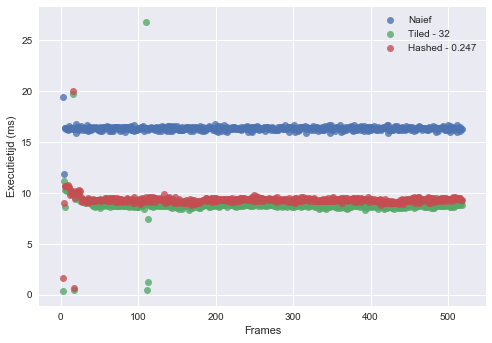

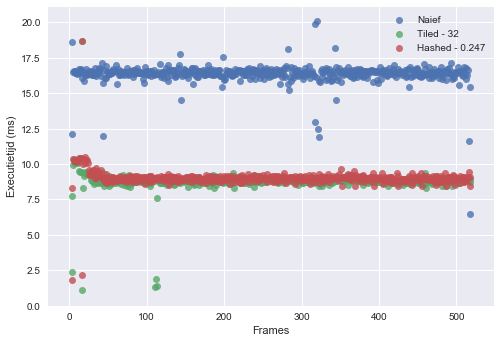

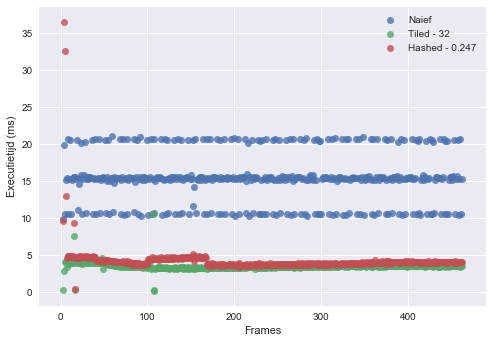

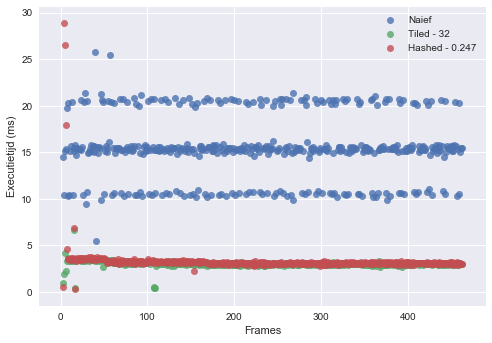

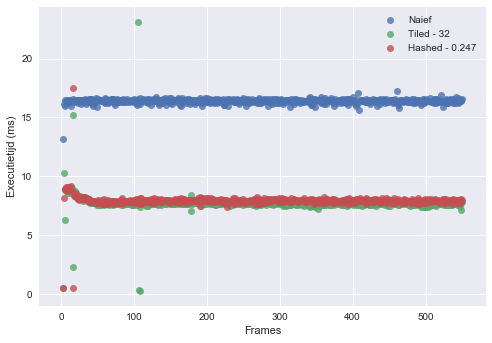

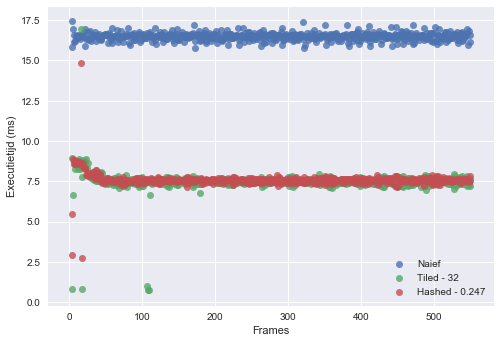

In [27]:
for scene in SCENES:
    for pt in ["forward", "deferred"]:
        plot_frame_low(scene, pt)

In [29]:
def export_frame_low(scene: str, pipeline_type: str ):
    # Collect data
    # ------------------------------------------------------------------
    df_attenuated = average_tests(extract_frames_low_data_frame_attenuated(scene, pipeline_type))
    col_list = list(x for x in df_attenuated if (x != 'index'))
    df_attenuated.loc[:, 'total'] = df_attenuated[col_list].sum(axis=1)
    
    df_tiled = average_tests(extract_frames_low_data_frame_tiled(scene, pipeline_type))
    col_list = list(x for x in df_tiled if (x != 'index'))
    df_tiled.loc[:, 'total'] = df_tiled[col_list].sum(axis=1)
    
    df_hashed = average_tests(extract_frames_low_data_frame_hashed(scene, 0, pipeline_type))
    col_list = list(x for x in df_hashed if (x != 'index'))
    df_hashed.loc[:, 'total'] = df_hashed[col_list].sum(axis=1)    

    # Plot data
    # ------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("index", "total", 
                data=df_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                fit_reg=False)
    
    sns.regplot("index", "total", 
                data=df_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                fit_reg=False)
    sns.regplot("index", "total", 
                data=df_hashed, #fit_reg=False,
                ax=ax,
                label="Hashed - 0.247",
                fit_reg=False)
    
    ax.set(xlabel='Frames', ylabel='Executietijd (ms)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    # Export file
    # -------------------------------------------------------------
    path = ANALYSIS_ROOT / Path("graphs/frames/{}/low/".format(pipeline_type))
    
    if not path.exists() or path.is_file():
        path.mkdir(parents=True)
        
    output_path = path / Path("frames_{}.svg".format(scene))
    fig.savefig(str(output_path), bbox_inches='tight')
    plt.close(fig)

In [30]:
for scene in SCENES:
    for pt in ["forward", "deferred"]:
        export_frame_low(scene, pt)

In [36]:
def extract_frames_high_data_frame_hashed(scene, node_size, pipeline_type):
    path_folder = RAW_DATA / Path("hashed_exec_resolution/{}/{}/2560/{}/".format(pipeline_type, scene, SCENES_HIGH[scene][node_size]))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result


def extract_frames_high_data_frame_tiled(scene, pipeline_type):
    path_folder = RAW_DATA / Path("tiled_exec_resolution/{}/{}/2560/".format(pipeline_type, scene))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result


def extract_frames_high_data_frame_attenuated(scene, pipeline_type):
    mp = {"pipers-alley":  "1044#3x_3y_2z", 
          "ziggurat-city": "1170#3x_3y_2z", 
          "spaceship-indoor": "1260#3x_3y_2z",
         }

    
    path_folder = RAW_DATA / Path("forward_deferred/{}/{}/{}/2560/".format(pipeline_type, scene, mp[scene]))
    
    result = []
    
    for i in range(N_TESTS):
        file_path = path_folder / Path("data_{}.json".format(i))
        with open(str(file_path), 'r') as f:
            data_json = json.loads(f.read())
        result.append(json_to_dataframe(data_json))
    return result

In [37]:
def plot_frame_high(scene: str, pipeline_type: str ):
    # Collect data
    # ------------------------------------------------------------------
    df_attenuated = average_tests(extract_frames_high_data_frame_attenuated(scene, pipeline_type))
    col_list = list(x for x in df_attenuated if (x != 'index'))
    df_attenuated.loc[:, 'total'] = df_attenuated[col_list].sum(axis=1)
    
    df_tiled = average_tests(extract_frames_high_data_frame_tiled(scene, pipeline_type))
    col_list = list(x for x in df_tiled if (x != 'index'))
    df_tiled.loc[:, 'total'] = df_tiled[col_list].sum(axis=1)
    
    df_hashed = average_tests(extract_frames_high_data_frame_hashed(scene, 0, pipeline_type))
    col_list = list(x for x in df_hashed if (x != 'index'))
    df_hashed.loc[:, 'total'] = df_hashed[col_list].sum(axis=1)    

    # Plot data
    # ------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("index", "total", 
                data=df_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                fit_reg=False)
    
    sns.regplot("index", "total", 
                data=df_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                fit_reg=False)
    sns.regplot("index", "total", 
                data=df_hashed, #fit_reg=False,
                ax=ax,
                label="Hashed - 0.247",
                fit_reg=False)
    
    ax.set(xlabel='Frames', ylabel='Executietijd (ms)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    # Export file
    # -------------------------------------------------------------
    plt.show()

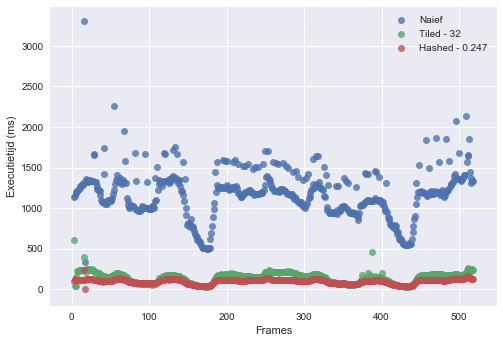

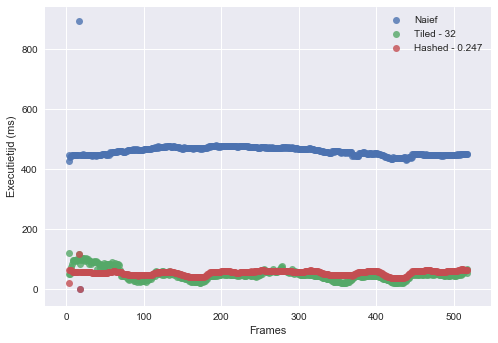

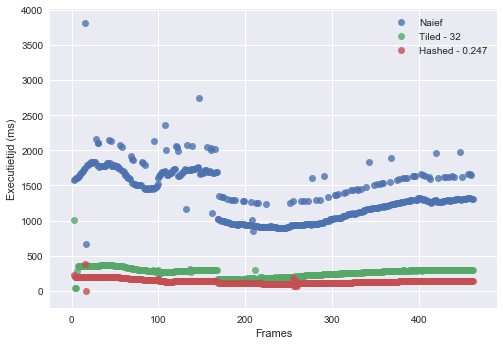

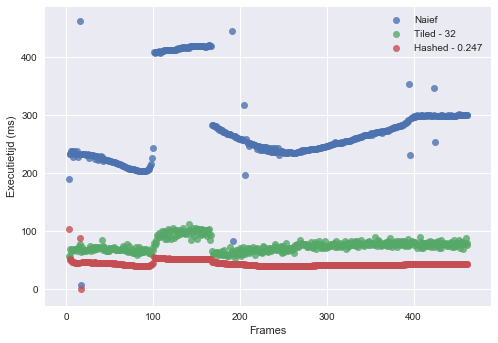

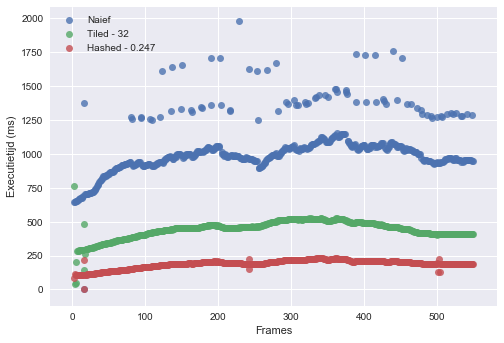

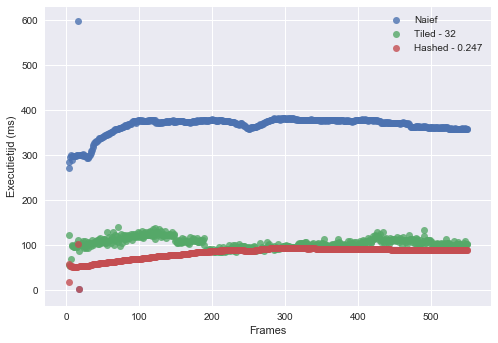

In [38]:
for scene in SCENES:
    for pt in ["forward", "deferred"]:
        plot_frame_high(scene, pt)

In [39]:
def export_frame_high(scene: str, pipeline_type: str ):
    # Collect data
    # ------------------------------------------------------------------
    df_attenuated = average_tests(extract_frames_high_data_frame_attenuated(scene, pipeline_type))
    col_list = list(x for x in df_attenuated if (x != 'index'))
    df_attenuated.loc[:, 'total'] = df_attenuated[col_list].sum(axis=1)
    
    df_tiled = average_tests(extract_frames_high_data_frame_tiled(scene, pipeline_type))
    col_list = list(x for x in df_tiled if (x != 'index'))
    df_tiled.loc[:, 'total'] = df_tiled[col_list].sum(axis=1)
    
    df_hashed = average_tests(extract_frames_high_data_frame_hashed(scene, 0, pipeline_type))
    col_list = list(x for x in df_hashed if (x != 'index'))
    df_hashed.loc[:, 'total'] = df_hashed[col_list].sum(axis=1)    

    # Plot data
    # ------------------------------------------------------------------
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    sns.regplot("index", "total", 
                data=df_attenuated, #fit_reg=False,
                ax=ax,
                label="Naief",
                fit_reg=False)
    
    sns.regplot("index", "total", 
                data=df_tiled, #fit_reg=False,
                ax=ax,
                label="Tiled - 32",
                fit_reg=False)
    sns.regplot("index", "total", 
                data=df_hashed, #fit_reg=False,
                ax=ax,
                label="Hashed - 0.247",
                fit_reg=False)
    
    ax.set(xlabel='Frames', ylabel='Executietijd (ms)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    # Export file
    # -------------------------------------------------------------
    path = ANALYSIS_ROOT / Path("graphs/frames/{}/high/".format(pipeline_type))
    
    if not path.exists() or path.is_file():
        path.mkdir(parents=True)
        
    output_path = path / Path("frames_{}.svg".format(scene))
    fig.savefig(str(output_path), bbox_inches='tight')
    plt.close(fig)

In [40]:
for scene in SCENES:
    for pt in ["forward", "deferred"]:
        export_frame_high(scene, pt)